# IANNWTF - Homework 06
(by Group 17 - Nils Niehaus, Philipp Bauer, Marlon Dammann)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

## 1 Data Set

We load the dataset:

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


and apply the appropriate preprocessing including normalizing, shuffling, prefetching and batching the data as well as onehotifying the targets:

In [3]:
def preprocess_dataset(data, target):
    '''We combine the image and target into one dataset'''
    data = tf.data.Dataset.from_tensor_slices((data, target))
    '''We one-hotify the target and cast into float32 for target and img'''
    data = data.map(lambda img, target: (tf.cast(img, 'float32'), tf.one_hot(target[0],depth=10, dtype='float32')))
    '''We normalize the color-values to a range of 0-1'''  
    data = data.map(lambda img, target: (img/255., target))  
    '''We shuffle, take a batch size of 64 and prefetch 20 elements.'''
    data = data.shuffle(1000)
    data = data.batch(64)
    data = data.prefetch(20)
    return data

In [4]:
train_ds = preprocess_dataset(x_train, y_train)
test_ds = preprocess_dataset(x_test, y_test)

## 2 Model

# ResNet:

In [5]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters_in=64, filters_out=256, mode='normal'):
        super(ResidualBlock, self).__init__()
        self.mode = mode
        self.ReLu = tf.keras.layers.Activation(tf.nn.relu)
        if mode == 'normal':
            self.batchnorm1 = tf.keras.layers.BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(1,1),padding='same')
            self.batchnorm2 = tf.keras.layers.BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(3,3),padding='same')
            self.batchnorm3 = tf.keras.layers.BatchNormalization()
            self.conv3 = tf.keras.layers.Conv2D(filters=filters_out,kernel_size=(1,1),padding='same')
            
            self.conv4 = tf.keras.layers.Conv2D(filters=filters_out,kernel_size=(1,1),padding='same')
            
            self.add = tf.keras.layers.Add()
        elif mode == 'strided':
            self.batchnorm1 = tf.keras.layers.BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(1,1),padding='same')
            self.batchnorm2 = tf.keras.layers.BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(3,3),padding='same',strides=(2,2))
            self.batchnorm3 = tf.keras.layers.BatchNormalization()
            self.conv3 = tf.keras.layers.Conv2D(filters=256,kernel_size=(1,1),padding='same')
            
            self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(1,1),strides=(2,2))
            
            self.add = tf.keras.layers.Add()
        elif mode == 'constant':
            self.batchnorm1 = tf.keras.layers.BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(1,1),padding='same')
            self.batchnorm2 = tf.keras.layers.BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(3,3),padding='same')
            self.batchnorm3 = tf.keras.layers.BatchNormalization()
            self.conv3 = tf.keras.layers.Conv2D(filters=filters_out,kernel_size=(1,1),padding='same')
    
    def call(self, x, is_train=False):
        if self.mode == 'normal':
            x1 = self.batchnorm1(x,training=is_train)
            x1 = self.ReLu(x1)
            x1 = self.conv1(x1)
            x1 = self.batchnorm2(x1,training=is_train)
            x1 = self.ReLu(x1)
            x1 = self.conv2(x1)
            x1 = self.batchnorm3(x1,training=is_train)
            x1 = self.ReLu(x1)
            x1 = self.conv3(x1)
            
            x2 = self.conv4(x)
            
            x = self.add([x1, x2])
        elif self.mode == 'strided':
            x1 = self.batchnorm1(x,training=is_train)
            x1 = self.ReLu(x1)
            x1 = self.conv1(x1)
            x1 = self.batchnorm2(x1,training=is_train)
            x1 = self.ReLu(x1)
            x1 = self.conv2(x1)
            x1 = self.batchnorm3(x1,training=is_train)
            x1 = self.ReLu(x1)
            x1 = self.conv3(x1)
            
            x2 = self.maxpool(x)
            
            x = self.add([x1, x2])
        elif self.mode == 'constant':
            x = self.batchnorm1(x,training=is_train)
            x = self.ReLu(x)
            x = self.conv1(x)
            x = self.batchnorm2(x,training=is_train)
            x = self.ReLu(x)
            x = self.conv2(x)
            x = self.batchnorm3(x,training=is_train)
            x = self.ReLu(x)
            x = self.conv3(x)
        return x

In [6]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.input_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')
        self.res_block1 = ResidualBlock(filters_in=64)
        self.res_block2 = ResidualBlock(filters_in=128,mode='strided')
        self.res_block3 = ResidualBlock(filters_in=256,mode='constant')
        self.glavgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(10,activation=tf.nn.softmax)
    
    def call(self, x, is_train=False):
        x = self.input_layer(x)
        x = self.res_block1(x,is_train=is_train)
        x = self.res_block2(x,is_train=is_train)
        x = self.res_block3(x,is_train=is_train)
        x = self.glavgpool(x)
        x = self.classifier(x)
        return x

# DenseNet:

In [7]:
class TransitionLayers(tf.keras.Model):
    def __init__(self, filters_in=64):
        super(TransitionLayers, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filters_in//2,kernel_size=(1,1),padding='valid',use_bias=False)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.ReLu = tf.keras.layers.Activation(tf.nn.relu)
        self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid')
    
    def call(self, x, is_train=False):
       # x = self.conv1(x)
        x = self.batchnorm(x,training=is_train)
        x = self.ReLu(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x

In [8]:
class DenseBlock(tf.keras.Model):
    def __init__(self, filters_in=128, filters_out=32):
        super(DenseBlock, self).__init__()
        self.ReLu = tf.keras.layers.Activation(tf.nn.relu)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=filters_in,kernel_size=(1,1),padding='valid',use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filters_out,kernel_size=(3,3),padding='same',use_bias=False)
    
    def call(self, x, is_train=False):
        x1 = self.bn1(x,training=is_train)
        x1 = self.ReLu(x1)
        x1 = self.conv1(x1)
        x1 = self.bn2(x1,training=is_train)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1)
        x = tf.keras.layers.Concatenate(axis=3)([x,x1])
        return x

In [9]:
class DenseNet(tf.keras.Model):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.input_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')
        self.dense_block6 = [DenseBlock() for _ in range(6)]
        self.transition1 = TransitionLayers(filters_in=32*7)
        output_shape = (32*7)//2
        self.dense_block12 = [DenseBlock() for _ in range(12)]
        self.transition2 = TransitionLayers(filters_in=output_shape+32*12)
        output_shape = (output_shape+32*12)//2
        self.dense_block24 = [DenseBlock() for _ in range(24)]
        self.transition3 = TransitionLayers(filters_in=output_shape+32*24)
        self.dense_block16 = [DenseBlock() for _ in range(16)]
        self.ReLu = tf.keras.layers.Activation(tf.nn.relu)
        self.bn = tf.keras.layers.BatchNormalization()
        self.glavgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(10,activation=tf.nn.softmax)
    
    def call(self, x, is_train=False):
        x = self.input_layer(x)
        for i in range(len(self.dense_block6)):
            x = self.dense_block6[i](x,training=is_train)
        x = self.transition1(x,training=is_train)
        for i in range(len(self.dense_block12)):
            x = self.dense_block12[i](x,training=is_train)
        x = self.transition2(x,training=is_train)
        for i in range(len(self.dense_block24)):
            x = self.dense_block24[i](x,training=is_train)
        x = self.transition3(x,training=is_train)
        for i in range(len(self.dense_block16)):
            x = self.dense_block16[i](x,training=is_train)
        x = self.bn(x)
        x = self.ReLu(x)
        x = self.glavgpool(x)
        x = self.classifier(x)
        return x

## 3 Training

In [10]:
model_performance = {
    'ResNet' : {
        'training': {'loss' : [], 'accuracy' : []},
        'test': {'loss' : [], 'accuracy' : []}
    },
    'DenseNet' : {
        'training': {'loss' : [], 'accuracy' : []},
        'test': {'loss' : [], 'accuracy' : []}
                 }
}

In [11]:
dataset = {'training' : train_ds, 'test' : test_ds}

In [12]:
def get_loss_and_accuracy(model, data_split, loss_function, mode_name):
    '''Returns the loss and accuracy of the model on a given split of the data.'''
    accuracy_aggregator = []
    loss_aggregator = []

    for (input, target) in tqdm(data_split,desc='Sampling Loss/Accuracy for ' + str(mode_name) + ' data'):
        prediction = model(input)
        sample_loss = loss_function(target, prediction)
        sample_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        loss_aggregator.append(sample_loss.numpy())
        accuracy_aggregator.append(np.mean(sample_accuracy))
        
    loss = tf.reduce_mean(loss_aggregator)
    accuracy = tf.reduce_mean(accuracy_aggregator)
    return loss, accuracy

In [13]:
def performance_test(model, data_split, loss_function, model_performance, mode_name, model_type):
    '''Evaluation of loss and accuracy of a model on a data split.'''
    loss, accuracy = get_loss_and_accuracy(model, data_split, loss_function, mode_name)
    model_performance[model_type][mode_name]['loss'].append(loss.numpy())
    model_performance[model_type][mode_name]['accuracy'].append(accuracy.numpy())
    if mode_name == 'test':
      print('Test accuracy for current epoch: ', model_performance[model_type][mode_name]['accuracy'][-1])

In [14]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input, is_train=True)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [15]:
def train_model(model, dataset, optimizer, loss_function, num_epochs, model_performance, model_type):
    for data, name in zip(list(dataset.values()),list(dataset.keys())):
        performance_test(model, data, loss_function, model_performance, mode_name=name, model_type=model_type)
    
    for epoch in range(num_epochs):
        for input,target in tqdm(dataset['training'],desc='Epoch '+str(epoch+1)):
            train_step(model, input, target, loss_function, optimizer)
            
        for data, name in zip(list(dataset.values()),list(dataset.keys())):
            performance_test(model, data, loss_function, model_performance, mode_name=name, model_type=model_type)

In [16]:
tf.keras.backend.clear_session()

'''Hyperparameters'''

'''The task was to use 30 epochs but we decided that it takes way too much time and does not change that much on our result. So we plotted with 10.'''
num_epochs = 10 
learning_rate = 0.001

'''Loss function'''
cat_cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

'''Adam as chosen optimizer'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

'''Models'''
resnet = ResNet()
densenet = DenseNet()

In [17]:
print('**Starting training for ResNet**')
train_model(resnet, dataset, optimizer, cat_cross_entropy_loss, num_epochs, model_performance, 'ResNet')

**Starting training for ResNet**


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 41.61it/s]


Test accuracy for current epoch:  0.10061703821656051


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 44.50it/s]


Test accuracy for current epoch:  0.42466162420382164


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 41.14it/s]


Test accuracy for current epoch:  0.46835191082802546


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 44.24it/s]


Test accuracy for current epoch:  0.5141321656050956


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 41.78it/s]


Test accuracy for current epoch:  0.6162420382165605


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 43.41it/s]


Test accuracy for current epoch:  0.5748407643312102


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 41.63it/s]


Test accuracy for current epoch:  0.714171974522293


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 40.95it/s]


Test accuracy for current epoch:  0.7259156050955414


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 40.43it/s]


Test accuracy for current epoch:  0.6081807324840764


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 43.38it/s]


Test accuracy for current epoch:  0.7412420382165605


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:03<00:00, 42.91it/s]

Test accuracy for current epoch:  0.6831210191082803


In [18]:
print('**Starting training for DenseNet**')
train_model(densenet, dataset, optimizer, cat_cross_entropy_loss, num_epochs, model_performance, 'DenseNet')

**Starting training for DenseNet**


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Test accuracy for current epoch:  0.09763136942675159


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:34<00:00,  4.56it/s]


Test accuracy for current epoch:  0.2870222929936306


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Test accuracy for current epoch:  0.431031050955414


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:34<00:00,  4.58it/s]


Test accuracy for current epoch:  0.5082603503184714


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:34<00:00,  4.55it/s]


Test accuracy for current epoch:  0.5572253184713376


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:34<00:00,  4.59it/s]


Test accuracy for current epoch:  0.5764331210191083


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:34<00:00,  4.57it/s]


Test accuracy for current epoch:  0.5874800955414012


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Test accuracy for current epoch:  0.6369426751592356


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Test accuracy for current epoch:  0.6541600318471338


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:34<00:00,  4.57it/s]


Test accuracy for current epoch:  0.6510748407643312


Sampling Loss/Accuracy for test data: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]

Test accuracy for current epoch:  0.6656050955414012


## 4 Visualization

Plotting the accuarcy and loss results via matplotlib.

In [19]:
def visualize_performance(model_type):
    fig, ax = plt.subplots(1,2,figsize=(15, 4))
    line1, = ax[0].plot(model_performance[model_type]['training']['loss'])
    line2, = ax[0].plot(model_performance[model_type]['test']['loss'])
    line3, = ax[1].plot(model_performance[model_type]['training']['accuracy'])
    line4, = ax[1].plot(model_performance[model_type]['test']['accuracy'])
    ax[0].set_xlabel("Training epoch")
    ax[0].set_ylabel("Loss")
    ax[1].set_xlabel("Training epoch")
    ax[1].set_ylabel("Accuracy")
    ax[0].legend((line1,line2),("training","test"))
    ax[1].legend((line3,line4),("training","test"))
    plt.show()

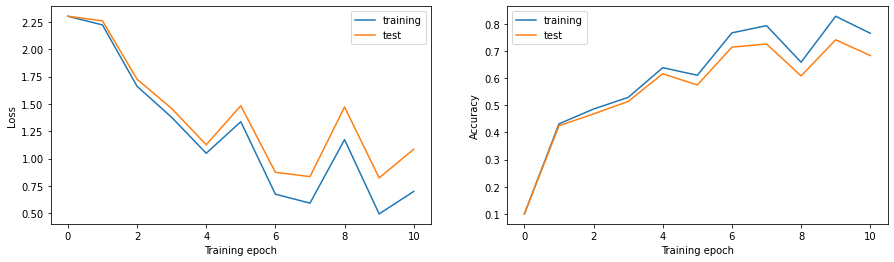

In [20]:
visualize_performance('ResNet')

In [21]:
print(model_performance['ResNet']['test']['accuracy'])

[0.10061703821656051, 0.42466162420382164, 0.46835191082802546, 0.5141321656050956, 0.6162420382165605, 0.5748407643312102, 0.714171974522293, 0.7259156050955414, 0.6081807324840764, 0.7412420382165605, 0.6831210191082803]


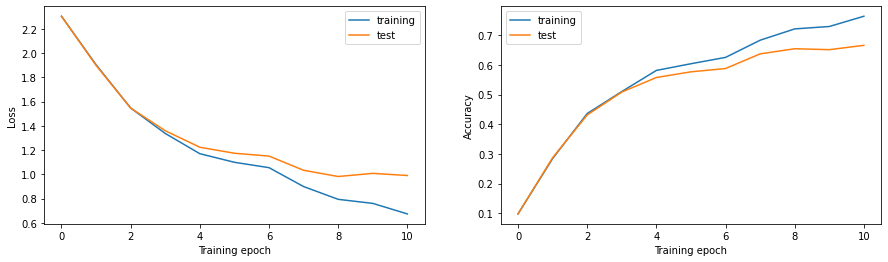

In [22]:
visualize_performance('DenseNet')

In [23]:
print(model_performance['DenseNet']['test']['accuracy'])

[0.09763136942675159, 0.2870222929936306, 0.431031050955414, 0.5082603503184714, 0.5572253184713376, 0.5764331210191083, 0.5874800955414012, 0.6369426751592356, 0.6541600318471338, 0.6510748407643312, 0.6656050955414012]


In [24]:
resnet.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 residual_block (ResidualBlo  multiple                 64768     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  multiple                 215552    
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  multiple                 724736    
 lock)                                                           
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                    

In [25]:
densenet.summary()

Model: "dense_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          multiple                  896       
                                                                 
 dense_block (DenseBlock)    multiple                  41600     
                                                                 
 dense_block_1 (DenseBlock)  multiple                  45824     
                                                                 
 dense_block_2 (DenseBlock)  multiple                  50048     
                                                                 
 dense_block_3 (DenseBlock)  multiple                  54272     
                                                                 
 dense_block_4 (DenseBlock)  multiple                  58496     
                                                                 
 dense_block_5 (DenseBlock)  multiple                  62

With both resnet and densenet models being more advanced than the simple CNN architecture from last weeks homework, they have to deal with way more parameters (around 120000 compared to around 1 million and 6 million respectively). This results is significantly more time neeed for training but rather similar performance on the given dataset with the densenet and somewhat worse performance with the resnet architecture which tends to overfit and fluctuating accuracy and loss results after a few epochs(ignoring the different batchsizes).